<a href="https://colab.research.google.com/github/pmags/datascience_master/blob/main/dask_bdcc2122.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Dask
**[Big Data and Cloud Computing]**

Dask provides a set of constructs that make it easier to parallelize data analysis tasks. It extends libraries such as numpy, pandas and scikit-learn allowing for efficient parallel and distributed execution, without major changes to their programming interfaces.


__Reference__:

- [python Dask](https://dask.org/)


Our first exercise is to play with dask arrays (extension of python numpy arrays). 

- Try the example below
- Vary the matrix dimensions and observe the behavior
- Go to [the chunks documentation web page](https://docs.dask.org/en/latest/array-chunks.html), play with chunks and observe the behavior
- Write a similar code in pure python numpy
    - Time both codes running
    - Observe how the execution time changes
- Enumerate you observations, discuss and conclude.

In [ ]:
import dask.array as da
x = da.ones((15, 15), chunks=(5, 5)
tic = time.time()
y = x + x.T
toc = time.time()
print("Time to build graph (seconds): ",toc-tic)
y.compute()
print("compute time (seconds): ",time.time()-toc)

Time to build graph (seconds):  0.023964881896972656
compute time (seconds):  0.02355504035949707


Let's have a look at the task graph:

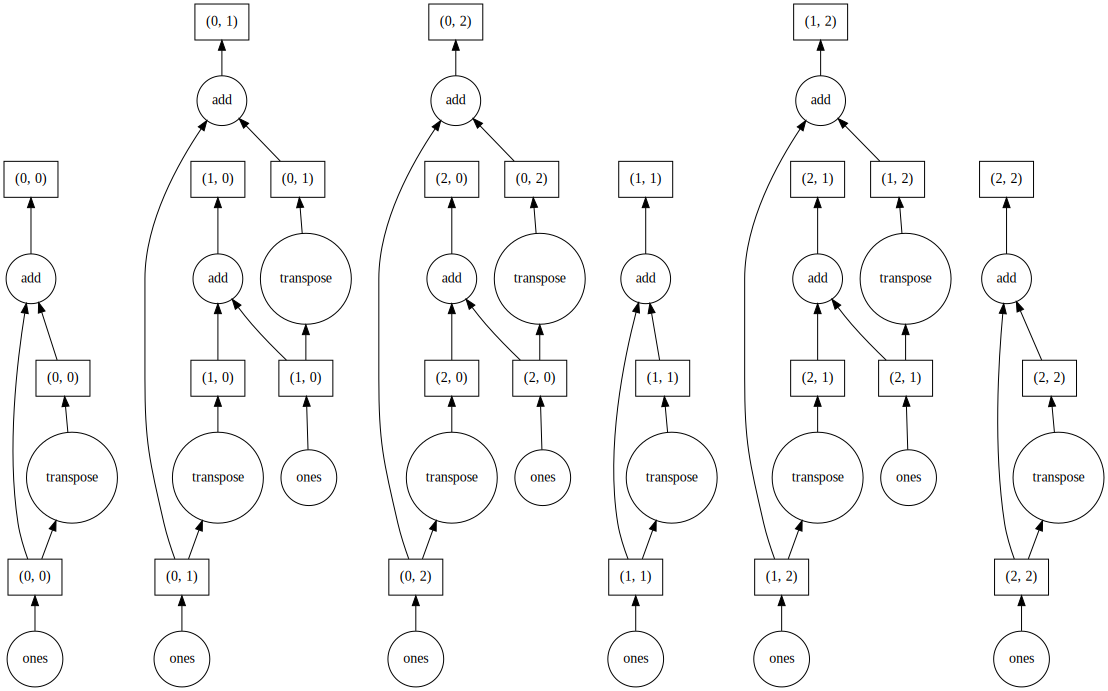

In [ ]:
y.visualize(filename='transpose.svg')

Explain this task graph.

The same program using numpy without dask.

In [ ]:
import time
import numpy as np

x = np.ones((1500, 1500))
tic = time.time()
y = x + x.T
print("Time in seconds: ",time.time()-tic)
y

Time in seconds:  0.02221536636352539


array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

Dask can implement a more general data structure: a bag. In the next example, we will be using a bag to put the contents of `json` files. But before starting, we need to install a package. Dask uses `fsspec` internally for its IO needs.

In [ ]:
!python -m pip install 'fsspec>=0.3.3'

For this exercise, we need multiple files that match the expression `2015-*-*-json.gz`. You can find such files in the [github archive](https://www.gharchive.org/). For example, try: `wget https://data.gharchive.org/2015-01-{01..31}-{0..23}.json.gz`. (I will stop the next command before all files are downloaded...).

I will create a directory to store these files.

In [ ]:
!mkdir json_files; cd json_files; wget https://data.gharchive.org/2015-01-{01..31}-{0..23}.json.gz

Alternatively, if you have the files in your own machine, you can execute the code below and upload these to the colab machine.

In [ ]:
from google.colab import files
uploaded = files.upload()

Now, let's do something with these files using dask bag. Note the wildcard (`*`) used to read mutiple files.

In [ ]:
import dask.bag as db
import json
b = db.read_text('json_files/2015-*-*.json.gz').map(json.loads)
b
b.pluck('type').frequencies().topk(10, lambda pair: pair[1]).compute()

[('PushEvent', 536592),
 ('CreateEvent', 110993),
 ('WatchEvent', 106709),
 ('IssueCommentEvent', 89704),
 ('IssuesEvent', 51225),
 ('PullRequestEvent', 42566),
 ('ForkEvent', 34876),
 ('DeleteEvent', 16929),
 ('PullRequestReviewCommentEvent', 11980),
 ('GollumEvent', 10539)]

b's visualization

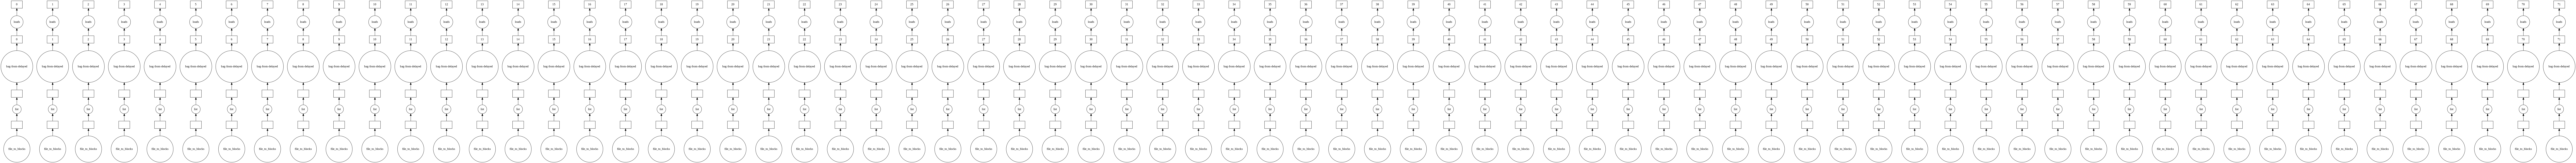

In [ ]:
b.visualize()

Visualizing the execution:

In [ ]:
b.pluck('type').frequencies().topk(10, lambda pair: pair[1]).visualize()

It's your turn now. Write a similar program and **do not** use dask. Do you see any difference in execution time?

Let's experiment some machine learning tasks. I will use the csv files of the [NYC taxi driver dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

In [ ]:
!mkdir taxi; cd taxi; for i in {01..12}; do wget https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2021-$i.parquet; done

mkdir: cannot create directory ‘taxi’: File exists
--2022-05-24 10:30:45--  https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2021-01.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.217.171.25
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.217.171.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21686067 (21M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2021-01.parquet’

yellow_tripdata_202 100%[===================>]  20.68M  49.7MB/s    in 0.4s    

2022-05-24 10:30:46 (49.7 MB/s) - ‘yellow_tripdata_2021-01.parquet’ saved [21686067/21686067]

--2022-05-24 10:30:46--  https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2021-02.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.216.147.180
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.216.147.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21777258

**For the tasks below, try your program with dask and without task.** The target variable is `fare_amount`. Use LinearRegression and XGBoost. Time the sequences of code.

1. Read the data 
2. Describe the data 
3. Perform a full ML pipeline
    - split the data into train/validation/test
    - train
4. report and compare results

This exercise is more about performance, but it's important to make sure that the models results are similar in both implementations: sequential and parallel.

Dask clients! **It does not seem to work in colab.** It works on the command line.

In order to make dask.distribute run you need to start at least 2 processes: a scheduler and a worker. They will be both waiting for some event to happen. The scheduler will wait for tasks from dask. The worker will be waiting for tasks from the scheduler.

Open three shell windows (in linux!). In one of them start the scheduler by typing: `dask-scheduler`. This command will start a new process that after writing some stuff on the screen will write its address as shown below:

`distributed.scheduler - INFO -   Scheduler at:   tcp://172.17.0.195:8786`

In a second shell window, you need to start a worker by typing: `dask-worker 172.17.0.195:8786`. This will create a second process that will be seating waiting for work. The result of this command will output something like:
```
ines@DESKTOP-C69M3MQ:~$ dask-worker tcp://172.17.0.195:8786
distributed.nanny - INFO -         Start Nanny at: 'tcp://172.17.0.195:64820'
distributed.worker - INFO -       Start worker at:   tcp://172.17.0.195:64821
distributed.worker - INFO -          Listening to:   tcp://172.17.0.195:64821
distributed.worker - INFO -          dashboard at:         172.17.0.195:64822
distributed.worker - INFO - Waiting to connect to:    tcp://172.17.0.195:8786
distributed.worker - INFO - -------------------------------------------------
distributed.worker - INFO -               Threads:                          8
distributed.worker - INFO -                Memory:                  15.60 GiB
distributed.worker - INFO -       Local Directory: /home/ines/dask-worker-space/worker-o_sv05vh
distributed.worker - INFO - -------------------------------------------------
```




Now, let's write a piece of code that will make dask interact with the scheduler. Create a python file with the code found in the next cell in your machine. Do not forget to replace the scheduler address in the code below with **your** scheduler address.

In [ ]:
import json
import dask.bag as db
from dask.distributed import Client

def summarize(l):
     # for f in l:
     #      n = f.pluck('type').frequencies().topk(10, lambda
pair: pair[1]).compute()
     # return n
     print(l)

def myread(f):
     return db.read_text(f).map(json.loads)

client = Client('tcp://172.17.0.195:8786') # you need to execu
te dask-scheduler and dask-worker on the command line if you w
ant to use a scheduler address and actual distributed computat
ion

filenames = []
for i in range(10): # taking files 01-01-(0..9)
     filenames.append("2015-01-01-"+str(i)+".json.gz")

futures = []
for fn in filenames:
     future = client.submit(myread, fn)
     futures.append(future)
     
summary = client.submit(summarize, futures)
summary.result()

In the remaining shell window run this code: `python pgm.py`.

Requirement: this program will look for files in disk. You need to a few of the `json.gz` files in your current directory.